In [ ]:
import mne, os, glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib qt 

In [2]:
"""
***Aestetics***
"""
# load color palette
my_palette = sns.color_palette().as_hex()
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [3]:
""" 
Load data
"""
# Big list
ep_list = []
# # Sup grouped list
# ep_group1 = []
# ep_group2 = []
# ep_group3 = []
# ep_group4 = []
# subjects = []
# Specify the epoch length we will be looking at
epoch_tmin = -0.1
epoch_tmax = 0.5

cleaned_data_dir = '/Users/mvmigem/Documents/data/project_1/preprocessed/mastoid_ref/'
dir_list = glob.glob(cleaned_data_dir+'*-epo.fif')
excuded_pp = [3,14,20]

for i,sub_path in enumerate(dir_list):
    sub = int(sub_path.split('main_eventset_mastoidref_')[1].split('-epo.fif')[0])
    if sub in excuded_pp:
        continue
    clean_epoch_path = sub_path
    epochs = mne.read_epochs(clean_epoch_path)
    epochs.info['bads']= []
    ep_list.append(epochs)

    # if epochs.metadata['loc_quad'].iloc[0] == 0:
    #     ep_group1.append(epochs)
    # elif epochs.metadata['loc_quad'].iloc[0] == 1:
    #     ep_group2.append(epochs)
    # elif epochs.metadata['loc_quad'].iloc[0] == 2:
    #     ep_group3.append(epochs)
    # elif epochs.metadata['loc_quad'].iloc[0] == 3:
    #     ep_group4.append(epochs)
    print(epochs.info['nchan'])

# Concat list into big epoch object
eps = mne.concatenate_epochs(ep_list).crop(tmin=epoch_tmin,tmax=epoch_tmax).apply_baseline()

Reading c:\Users\mvmigem\Documents\data\project_1\preprocessed\mastoid_ref\main_eventset_mastoidref_01-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 33 columns
4189 matching events found
No baseline correction applied
0 projection items activated
69
Reading c:\Users\mvmigem\Documents\data\project_1\preprocessed\mastoid_ref\main_eventset_mastoidref_02-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 33 columns
4196 matching events found
No baseline correction applied
0 projection items activated
69
Reading c:\Users\mvmigem\Documents\data\project_1\preprocessed\mastoid_ref\main_eventset_mastoidref_04-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 33 columns
4200 matching events f

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_34284\1304716375.py:40: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  eps = mne.concatenate_epochs(ep_list).crop(tmin=epoch_tmin,tmax=epoch_tmax).apply_baseline()


Adding metadata with 35 columns
94647 matching events found
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [4]:

sub_list = eps.metadata['participant'].unique() 

# Divide the epoch file into sections based on metadata that can't be distinguished by event names
# Drop catch trials
epochs_nocatch = eps.copy()['catch_trial == 0']

# metadata['visual_field'] = np.where(metadata['loc_quad'].isin([1, 2]), 'up', 'down')

# # Divide attention conditions
# epochs_attended = epochs_nocatch['attention == "attended"']
# epochs_unattended = epochs_nocatch['attention == "unattended"']
# # Divide by staring position
# epochs_start3 = epochs_nocatch['start_position == 2']
# epochs_start1 = epochs_nocatch['start_position == 0']
# epochs_start2 = epochs_nocatch['start_position == 1']
# epochs_start4 = epochs_nocatch['start_position == 3']
# # Divide unattended trials by start pos
# epochs_unattended_start3 = epochs_unattended['start_position == 2']
# epochs_unattended_start1 = epochs_unattended['start_position == 0']
# epochs_unattended_start2 = epochs_unattended['start_position == 1']
# epochs_unattended_start4 = epochs_unattended['start_position == 3']
# # Divide attented trials by start pos
# epochs_attended_start3 = epochs_attended['start_position == 2']
# epochs_attended_start1 = epochs_attended['start_position == 0']
# epochs_attended_start2 = epochs_attended['start_position == 1']
# epochs_attended_start4 = epochs_attended['start_position == 3']
# # Extra devision for the odd boys
# epochs_attended_reg = epochs_attended['expected =="regular"']
# epochs_attended_odd = epochs_attended['expected == "odd"']
# epochs_unattended_reg = epochs_unattended['expected =="regular"']
# epochs_unattended_odd = epochs_unattended['expected == "odd"']

### Evoked plotting

In [5]:
"""
Main pos individual channels
"""
evoked_pos1_list = []
evoked_pos2_list = []
evoked_pos3_list = []
evoked_pos4_list = []
for i,sub in enumerate(sub_list):
    evoked_pos1_list.append(epochs_nocatch['pos1'][f'participant == {sub}'].average())
    evoked_pos2_list.append(epochs_nocatch['pos2'][f'participant == {sub}'].average())
    evoked_pos3_list.append(epochs_nocatch['pos3'][f'participant == {sub}'].average())
    evoked_pos4_list.append(epochs_nocatch['pos4'][f'participant == {sub}'].average())

evoked_pos1 = mne.grand_average(evoked_pos1_list)
evoked_pos2 = mne.grand_average(evoked_pos2_list)
evoked_pos3 = mne.grand_average(evoked_pos3_list)
evoked_pos4 = mne.grand_average(evoked_pos4_list)

evokeds_list = [evoked_pos1,evoked_pos2,evoked_pos3,evoked_pos4]
conds = ('pos1','pos2','pos3','pos4')
# conds = ('seq1','seq2','seq3','seq4')

norm = dict(zip(conds, evokeds_list))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

In [6]:
# Load peak properties of localiser data
peak_properties = pd.read_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_peak_properties.csv')

In [ ]:
# Previous peak_properties dataframe uses peak latencies 
# based on the localiser data which may not be optimal
# so I'm now making another dataframe to select the latencies
# of the main experiment

evokeds_lists = [evoked_pos1_list,evoked_pos2_list,evoked_pos3_list,evoked_pos4_list]

all_pos = []
pos1 = []
pos2 = []
pos3 = []
pos4 = []

positions = [pos1,pos2,pos3,pos4]
peak_variables = ['peak_channel','peak_latency','peak_amplitude','subject']

for i,sub in enumerate(sub_list):
    the_row = peak_properties[peak_properties['subject'] == sub]
    av_list = []
    for ind,evoked in enumerate(evokeds_lists):
        channel = the_row[f'pos{ind+1}_peak_channel'].iloc[0]
        roi_ev = evoked[i].copy().pick(channel)
        
        # mode = 'pos'
        # if ind == 0 or ind == 1:
        #     mode = 'neg
        ch,lat,amp = roi_ev.get_peak(ch_type='eeg',
                                    tmin=0.06,tmax=0.09,
                                    mode= 'abs',
                                    return_amplitude=True)
        positions[ind].append(dict(zip(peak_variables,(ch,lat,amp,sub))))

        # rms the tailored latencies
        ev_data = evoked[i].data
        rootsqr_data = np.sqrt((ev_data**2))
        rsq_ev = mne.EvokedArray(rootsqr_data,evoked[i].info,tmin=evoked[i].times[0])
        av_list.append(rsq_ev)
    # also for the tailored latencies
    all_pos_channel = the_row['all_pos_peak_channel'].iloc[0]
    merged_ev = mne.grand_average(av_list)
    ch,lat,amp = merged_ev.get_peak(ch_type='eeg',   
                                tmin=0.06,tmax=0.09,
                                return_amplitude=True)
    all_pos.append(dict(zip(peak_variables,(ch,lat,amp))))

main_all_pos = pd.DataFrame(all_pos)
main_all_pos.rename(columns={'peak_channel':'all_pos_peak_channel',
                             'peak_latency':'all_pos_peak_latency',
                             'peak_amplitude':'all_pos_peak_amplitude'},inplace=True)
main_pos1 = pd.DataFrame(positions[0])
main_pos1.rename(columns={'peak_channel':'pos1_peak_channel',
                          'peak_latency':'pos1_peak_latency',
                          'peak_amplitude':'pos1_peak_amplitude'},inplace=True)
main_pos1.drop(columns=['subject'],inplace=True)
main_pos2 = pd.DataFrame(positions[1])
main_pos2.rename(columns={'peak_channel':'pos2_peak_channel',
                          'peak_latency':'pos2_peak_latency',
                          'peak_amplitude':'pos2_peak_amplitude'},inplace=True)
main_pos2.drop(columns='subject',inplace=True)
main_pos3 = pd.DataFrame(positions[2])
main_pos3.rename(columns={'peak_channel':'pos3_peak_channel',
                          'peak_latency':'pos3_peak_latency',
                          'peak_amplitude':'pos3_peak_amplitude'},inplace=True)
main_pos3.drop(columns='subject',inplace=True)
main_pos4 = pd.DataFrame(positions[3])
main_pos4.rename(columns={'peak_channel':'pos4_peak_channel',
                          'peak_latency':'pos4_peak_latency',
                          'peak_amplitude':'pos4_peak_amplitude'},inplace=True)
main_pos4.drop(columns='subject',inplace=True)
general_pos = peak_properties[peak_properties['subject'].isin(sub_list)]

general_pos = general_pos[['grand_average_peak_channel',
                                'grand_average_peak_latency',
                                'grand_average_peak_amplitude',
                                'subject']].reset_index(drop=True)

main_pos = [main_all_pos,main_pos1,main_pos2,main_pos3,main_pos4,general_pos]
main_pos_df = pd.concat(main_pos,axis=1)

In [ ]:
peak_properties = main_pos_df

In [ ]:
for i,sub in enumerate(sub_list):
    
    evokeds_list = [evoked_pos1_list[i],evoked_pos2_list[i],evoked_pos3_list[i],evoked_pos4_list[i]]
    conds = ('pos1','pos2','pos3','pos4')
    # conds = ('seq1','seq2','seq3','seq4')
    norm = dict(zip(conds, evokeds_list))
    # mne.viz.plot_compare_evokeds(norm,picks=['POz'],vlines=[0.05,0.1],ylim=dict(eeg=[-6,6]))
    epochs_nocatch['pos1'][f'participant == {sub}'].plot_image(picks=['POz','Pz','Oz'],vmin=-80,vmax=80,combine='mean')


In [ ]:
scale = [-12,12]


for i,sub in enumerate(sub_list):
    fig, axes = plt.subplots(1,2, figsize=(12, 6), sharey=True)
    the_row = peak_properties[peak_properties['subject'] == sub]
    channel = the_row['all_pos_peak_channel'].iloc[0]

    ev_names = ('pos1','pos2','pos3','pos4')
    evokeds_list = [evoked_pos1_list[i],evoked_pos2_list[i],evoked_pos3_list[i],evoked_pos4_list[i]]
    # conds = ('seq1','seq2','seq3','seq4')
    norm = dict(zip(ev_names, evokeds_list))

    mne.viz.plot_compare_evokeds(norm, picks='POz', axes=axes[0], vlines=[0.05,0.1],ylim=dict(eeg=scale))
    mne.viz.plot_compare_evokeds(norm, picks=channel, axes=axes[1], vlines=[0.05,0.1],ylim=dict(eeg=scale))
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the figure
    plt.show()

In [ ]:
scale = [-12,12]
evokeds_lists = [evoked_pos1_list,evoked_pos2_list,evoked_pos3_list,evoked_pos4_list]
for i,sub in enumerate(sub_list):
    # init fig
    fig, axes = plt.subplots(1,2, figsize=(12, 6), sharey=True)
    # take times from single evoked ( should be all the same)
    times = evoked_pos1_list[0].times
    # take sub loc peak info
    the_row = peak_properties[peak_properties['subject'] == sub]
    # iter over positions
    for idx in range(4):
        standard = evokeds_lists[idx][i].copy().pick('POz').data.squeeze() * 1e6
        sns.lineplot(x=times, y=standard, ax = axes[0], label = f'Pos{idx+1} POz')
        channel = the_row[f'pos{idx+1}_peak_channel'].iloc[0]
        selected = evokeds_lists[idx][i].copy().pick(channel).data.squeeze() * 1e6
        sns.lineplot(x=times, y=selected, ax = axes[1],label = f'Pos{idx+1} {channel}')

    # mne.viz.plot_compare_evokeds(norm, picks='POz', axes=axes[1], vlines=[0.05,0.1],ylim=dict(eeg=scale))

    axes[0].axhline(y=0, lw=1, c='black' )
    axes[1].axhline(y=0, lw=1, c='black' )
    axes[0].axvline(x=.05,ls='--',lw=1, c='black' )
    axes[0].axvline(x=.1,ls='--',lw=1, c='black' )
    axes[1].axvline(x=.05,ls='--',lw=1, c='black' )
    axes[1].axvline(x=.1,ls='--',lw=1, c='black' )
    axes[0].set_title('Fixed channel')
    axes[1].set_title('Variable channel')
    axes[0].set_ylabel('µV')
    axes[0].set_xlabel('time (s)')
    axes[1].set_xlabel('time (s)')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the figure
    plt.show()

In [5]:
# Event selection for prediction effects

# Remove catch
# epochs_nocatch = eps.copy()['catch_trial == 0']['pos4']
# Select second stim of trial
epochs_stim2 = epochs_nocatch['seq2']
# Regular vs odd
epochs_odd = epochs_stim2['expected == "odd"']
epochs_reg = epochs_stim2['expected == "regular"']['precedes_odd == 1']
# Attention
ep_odd_att = epochs_odd['attention == "attended"']
ep_odd_unatt = epochs_odd['attention == "unattended"']
ep_reg_att = epochs_reg['attention == "attended"']
ep_reg_unatt = epochs_reg['attention == "unattended"']


In [7]:
recombined_epoch = mne.concatenate_epochs([ep_reg_att, ep_odd_att,ep_reg_unatt,ep_odd_unatt])
recombined_epoch.save(f"C:/Users/mvmigem/Documents/data/project_1/uncorrected_epochs/uncorrected_epochs-epo.fif", overwrite=True)

Adding metadata with 35 columns
9025 matching events found
Applying baseline correction (mode: mean)


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_34284\2522273327.py:2: RuntimeWarning: epochs.drop_log contains 386612 entries which will incur up to a 4.8 MB writing overhead (per split file), consider using epochs.reset_drop_log_selection() prior to writing
  recombined_epoch.save(f"C:/Users/mvmigem/Documents/data/project_1/uncorrected_epochs/uncorrected_epochs-epo.fif", overwrite=True)


In [14]:
""" 
Counting the amount of trials for every processing step
"""

df_to_count = epochs_reg.metadata
# df_to_count = df_to_count[~(df_to_count.index % 5 == 0)] # have to kind of decimate


grouped = df_to_count.groupby(['participant', 'attention', 'expected']).size().reset_index(name='row_count')

# Step 3: Group by attention and expectation, and calculate the mean and standard deviation
stats_per_condition = grouped.groupby(['attention', 'expected'])['row_count'].agg(['mean', 'std']).reset_index()

In [ ]:
"""
checking prediction manipulation on p3, means agragating across positions 
"""
att_reg_ev = []
att_odd_ev = []
unatt_reg_ev = []
unatt_odd_ev = []
# totals_grand = []


for i, sub in enumerate(sub_list):
    
    att_reg_ev.append(
        epochs_nocatch['seq2'][f"participant == {sub}"]["attention == 'attended'"]['expected == "regular"']['precedes_odd == 1'].average())
    att_odd_ev.append(
        epochs_nocatch['seq2'][f"participant == {sub}"]["attention == 'attended'"]['expected == "odd"'].average())
    unatt_reg_ev.append(
        epochs_nocatch['seq2'][f"participant == {sub}"]["attention == 'unattended'"]['expected == "regular"']['precedes_odd == 1'].average())
    unatt_odd_ev.append(
        epochs_nocatch['seq2'][f"participant == {sub}"]["attention == 'unattended'"]['expected == "odd"'].average())
    
    # totals_grand.append(
    #     epochs_nocatch['seq2'].average())
    

In [ ]:

evoked_pred = [mne.grand_average(att_reg_ev),
               mne.grand_average(att_odd_ev),
               mne.grand_average(unatt_reg_ev),
               mne.grand_average(unatt_odd_ev),]

conditions = ('attended regular','attended odd','unattended regular','unattended odd')

norm = dict(zip(conditions, evoked_pred))

In [ ]:
""" 
create df with the neededed values for p3 analysis
"""
# init df
long_sub_list = [item for item in sub_list for _ in range(4)]
p3_df = pd.DataFrame(long_sub_list, columns=['subject'])

# selected channels
roi = ['P1','Pz','P2','CP1','CPz','CP2','C1','Cz','C2']
roi_ix = mne.pick_channels(epochs_nocatch[0].info["ch_names"], include=roi)
roi_dict = dict(centropar = list(roi_ix))
p3_tmin, p3_tmax = 0.25, 0.45

# loop subjects
mid_att = []
mid_pred = []
mid_peak = []
mid_lat = []
mid_mean = []
sub_check = []
for i, sub in enumerate(sub_list):
    print(sub)
    # attended and regular
    ev_roi = mne.channels.combine_channels(inst = att_reg_ev[i], groups= roi_dict)
    mean_amp = ev_roi.crop(tmin=p3_tmin,tmax=p3_tmax).data.mean(axis=1) * 1e6
    mid_att.append('attended')
    mid_pred.append('regular')
    mid_mean.append(mean_amp[0])
    sub_check.append(sub)
    # attended and odd
    ev_roi = mne.channels.combine_channels(inst = att_odd_ev[i], groups= roi_dict)
    mean_amp = ev_roi.crop(tmin=p3_tmin,tmax=p3_tmax).data.mean(axis=1) * 1e6
    mid_att.append('attended')
    mid_pred.append('odd')
    mid_mean.append(mean_amp[0])
    sub_check.append(sub)
    # unattended and regular
    ev_roi = mne.channels.combine_channels(inst = unatt_reg_ev[i], groups= roi_dict)
    mean_amp = ev_roi.crop(tmin=p3_tmin,tmax=p3_tmax).data.mean(axis=1) * 1e6
    mid_att.append('unattended')
    mid_pred.append('regular')
    mid_mean.append(mean_amp[0])
    sub_check.append(sub)
    # unattended and odd
    ev_roi = mne.channels.combine_channels(inst = unatt_odd_ev[i], groups= roi_dict)
    mean_amp = ev_roi.crop(tmin=p3_tmin,tmax=p3_tmax).data.mean(axis=1) * 1e6
    mid_att.append('unattended')
    mid_pred.append('odd')
    mid_mean.append(mean_amp[0])
    sub_check.append(sub)

p3_df['attention'] = mid_att
p3_df['expectation'] = mid_pred
p3_df['mean_amp'] = mid_mean



In [15]:
p3_df.to_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\p3_df.csv',index= False)

In [8]:
"""
Main effects 
"""
reg_att_up = []
odd_att_up = []
reg_unatt_up = []
odd_unatt_up = []

reg_att_down = []
odd_att_down = []
reg_unatt_down = []
odd_unatt_down = []

cond_ep_lists = [ep_reg_att,ep_odd_att,ep_reg_unatt,ep_odd_unatt] 
up_conds = [reg_att_up,odd_att_up,reg_unatt_up,odd_unatt_up]  
down_conds = [reg_att_down,odd_att_down,reg_unatt_down,odd_unatt_down]  
ev_names = ['reg_att','odd_att','reg_unatt','odd_unatt']
# List to know which position was used to select the up or down later
sub_pos_info = []

evokeds_up = dict(zip(ev_names,up_conds))
evokeds_down = dict(zip(ev_names,down_conds))

for i, sub in enumerate(sub_list):
    # which set of positions does this sub have
    loc_quad_values = ep_reg_att[f'participant == {sub}'].metadata["loc_quad"]
    loc_quad_value = loc_quad_values.unique()[0]
    # Dict to stor positional info
    sub_info_dict = {}
    sub_info_dict['subject'] = sub
    # Positions 1 and 3
    if loc_quad_value == 0  or loc_quad_value== 2 :
        # make dict to store the selected evokeds
        ev_position1 = {}
        # for every condition
        for i, epoch in enumerate(cond_ep_lists):
            # transform the epochs into evokeds
            ev_position1[ev_names[i]] = epoch['pos1'][f'participant == {sub}'].average()
        # same for position 3
        ev_position3 = {}
        for i, epoch in enumerate(cond_ep_lists):
            ev_position3[ev_names[i]] = epoch['pos3'][f'participant == {sub}'].average()
        # for every condition in the upper vf
        for cond,evoked in ev_position1.items():
            evokeds_up[cond].append(evoked)
        # same for down
        for cond,evoked in ev_position3.items():
            evokeds_down[cond].append(evoked)
        # Store position information
        sub_info_dict['up_pos'] = 1
        sub_info_dict['down_pos'] = 3
    # same for positions 2 and 4
    if loc_quad_value == 1  or loc_quad_value== 3 :
        ev_position2 = {}
        for i, evoked in enumerate(cond_ep_lists):
            ev_position2[ev_names[i]] = evoked['pos2'][f'participant == {sub}'].average()
        ev_position4 = {}
        for i, evoked in enumerate(cond_ep_lists):
            ev_position4[ev_names[i]] = evoked['pos4'][f'participant == {sub}'].average()
        # for every condition in the upper vf
        for cond,evoked in ev_position2.items():
            # append to that conditions list in the up_dict
            evokeds_up[cond].append(evoked)
        # same for lower vf
        for cond,evoked in ev_position4.items():
            evokeds_down[cond].append(evoked)
        sub_info_dict['up_pos'] = 2
        sub_info_dict['down_pos'] = 4
    # Add info_dict_to list
    sub_pos_info.append(sub_info_dict)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

In [26]:
# Load peak properties of localiser data
peak_properties = pd.read_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_peak_properties.csv')

In [9]:
# transfrom dict of lists to list of dicts for plotting individually
subj_uplist = [dict(zip(evokeds_up, values)) for values in zip(*evokeds_up.values())]
subj_downlist = [dict(zip(evokeds_down, values)) for values in zip(*evokeds_down.values())]

In [11]:
# Create dataframes for export and analysis
long_sub_list = [item for item in sub_list for _ in range(4)]
c1_long_df = pd.DataFrame(long_sub_list, columns=['subject'])
window_halfwidth = 0.01
# Condition columns
mid_att = []
mid_pred = []
# General analysis list init 
genup_amp = []
gendown_amp = []
general_amp = []
# General time window estimate
gen_lat = peak_properties['grand_average_peak_latency'][0]
gen_tmin = gen_lat - window_halfwidth
gen_tmax = gen_lat + window_halfwidth
# 
selectup_gen_evoked = []
selectdown_gen_evoked = []

# Tailored analysis empty lists
tailup_amp = []
taildown_amp = []
tailored_amp =[]

selectup_tail_evoked = []
selectdown_tail_evoked = []

# Ultra tailored analysis values 
ultraup_amp = []
ultradown_amp = []
ultra_amp = []
ultraup_tmins = []
ultraup_tmaxs = []
ultradown_tmins = []
ultradown_tmaxs = []

selectup_ultra_evoked = []
selectdown_ultra_evoked = []

conditions_att = ['attended','attended','unattended','unattended',]
conditions_pred = ['regular','odd','regular','odd',]
conditions = ['reg_att','odd_att','reg_unatt','odd_unatt']

# Static C1 window selection
for i, sub in enumerate(sub_list):
    # Dicts to store the selected evoked
    upgen_select_dict = {}
    downgen_select_dict = {}
    uptail_select_dict = {}
    downtail_select_dict = {}
    upultra_select_dict = {}
    downultra_select_dict = {}
    # Select the channel and latency based on localiser info
    sub_row = peak_properties[peak_properties['subject'] == sub_pos_info[i]['subject']]
    # Tailored info
    tailored_channel = sub_row['all_pos_peak_channel'].iloc[0]
    tailored_latency = sub_row['all_pos_peak_latency'].iloc[0]
    tail_tmin = tailored_latency - window_halfwidth
    tail_tmax = tailored_latency + window_halfwidth
    # Ultra tailored info
    up_pos = sub_pos_info[i]['up_pos']
    down_pos = sub_pos_info[i]['down_pos']
    ultraup_channel = sub_row[f'pos{up_pos}_peak_channel'].iloc[0]
    ultradown_channel = sub_row[f'pos{down_pos}_peak_channel'].iloc[0]
    ultraup_latency = sub_row[f'pos{up_pos}_peak_latency'].iloc[0]
    ultradown_latency = sub_row[f'pos{up_pos}_peak_latency'].iloc[0]
    ultraup_tmin = ultraup_latency - window_halfwidth
    [ultraup_tmins.append(ultraup_tmin) for p in range(4)]
    ultraup_tmax = ultraup_latency + window_halfwidth
    [ultraup_tmaxs.append(ultraup_tmax) for p in range(4)]
    ultradown_tmin = ultradown_latency - window_halfwidth
    [ultradown_tmins.append(ultradown_tmin) for p in range(4)]
    ultradown_tmax = ultradown_latency + window_halfwidth
    [ultradown_tmaxs.append(ultradown_tmax) for p in range(4)]

    for ind in range(4):
        # attended and regular
        mid_att.append(conditions_att[ind])
        mid_pred.append(conditions_pred[ind])
        # General
        # Pick channel
        gen_selected_up = subj_uplist[i][conditions[ind]].copy().pick(['POz']) 
        gen_selected_down = subj_downlist[i][conditions[ind]].copy().pick(['POz'])
        upgen_select_dict[conditions[ind]] =  gen_selected_up
        downgen_select_dict[conditions[ind]] =  gen_selected_down
        # Extract data
        gen_up_mean_data = gen_selected_up.copy().crop(tmin=gen_tmin,tmax=gen_tmax).data
        gen_down_mean_data = gen_selected_down.copy().crop(tmin=gen_tmin,tmax=gen_tmax).data
        # Agragate and append
        genup_mean = gen_up_mean_data.mean(axis=1) * 1e6
        gendown_mean = gen_down_mean_data.mean(axis=1) * 1e6
        genup_amp.append(genup_mean[0])
        gendown_amp.append(gendown_mean[0])
        # RMS
        gen_mean = np.mean([np.sqrt(genup_mean**2),np.sqrt(gendown_mean**2)])
        general_amp.append(gen_mean)

        # Tailored
        # Pick channel
        tail_selected_up = subj_uplist[i][conditions[ind]].copy().pick([tailored_channel]) 
        tail_selected_down = subj_downlist[i][conditions[ind]].copy().pick([tailored_channel])
        uptail_select_dict[conditions[ind]] =  tail_selected_up
        downtail_select_dict[conditions[ind]] =  tail_selected_down
        # Extract data
        tail_up_mean_data = tail_selected_up.copy().crop(tmin=tail_tmin,tmax=tail_tmax).data
        tail_down_mean_data = tail_selected_down.copy().crop(tmin=tail_tmin,tmax=tail_tmax).data
        # Agragate and append
        tailup_mean = tail_up_mean_data.mean(axis=1) * 1e6
        taildown_mean = tail_down_mean_data.mean(axis=1) * 1e6
        tailup_amp.append(tailup_mean[0])
        taildown_amp.append(taildown_mean[0])
        # RMS
        tail_mean = np.mean([np.sqrt(tailup_mean**2),np.sqrt(taildown_mean**2)])
        tailored_amp.append(tail_mean)

        # Ultra tailored
        # Pick channel
        ultra_selected_up = subj_uplist[i][conditions[ind]].copy().pick([ultraup_channel]) 
        ultra_selected_down = subj_downlist[i][conditions[ind]].copy().pick([ultradown_channel])
        upultra_select_dict[conditions[ind]] =  ultra_selected_up
        downultra_select_dict[conditions[ind]] =  ultra_selected_down
        # Extract data
        ultra_up_mean_data = ultra_selected_up.copy().crop(tmin=ultraup_tmin,tmax=ultraup_tmax).data
        ultra_down_mean_data = ultra_selected_down.copy().crop(tmin=ultradown_tmin,tmax=ultradown_tmax).data
        # Agragate and append
        ultraup_mean = ultra_up_mean_data.mean(axis=1) * 1e6
        ultradown_mean = ultra_down_mean_data.mean(axis=1) * 1e6
        ultraup_amp.append(ultraup_mean[0])
        ultradown_amp.append(ultradown_mean[0])
        # RMS
        ultra_mean = np.mean([np.sqrt(ultraup_mean**2),np.sqrt(ultradown_mean**2)])
        ultra_amp.append(ultra_mean)
    
    selectup_gen_evoked.append(upgen_select_dict)
    selectdown_gen_evoked.append(downgen_select_dict) 
    selectup_tail_evoked.append(uptail_select_dict)
    selectdown_tail_evoked.append(downtail_select_dict) 
    selectup_ultra_evoked.append(uptail_select_dict)
    selectdown_ultra_evoked.append(downtail_select_dict) 

c1_long_df['attention'] = mid_att
c1_long_df['expectation'] = mid_pred
c1_long_df['general_amp'] = general_amp
c1_long_df['general_up_amp'] = genup_amp
c1_long_df['general_down_amp'] = gendown_amp
c1_long_df['tailored_amp'] = tailored_amp
c1_long_df['tailored_up_amp'] = tailup_amp
c1_long_df['tailored_down_amp'] = taildown_amp
c1_long_df['ultra_amp'] = ultra_amp
c1_long_df['ultra_up_amp'] = ultraup_amp
c1_long_df['ultra_down_amp'] = ultradown_amp
c1_long_df['ultra_up_tmin'] = ultraup_tmins
c1_long_df['ultra_up_tmax'] = ultraup_tmaxs
c1_long_df['ultra_down_tmin'] = ultradown_tmins
c1_long_df['ultra_down_tmax'] = ultradown_tmaxs


In [12]:
# Correct dataframe for subjects 8 and 9 having truncated datasets (lost trials)
c1_long_df.loc[(c1_long_df['subject'] == 9) & (c1_long_df['attention'] == 'attended') & (c1_long_df['expectation'] == 'odd'), 
       ['general_up_amp', 'tailored_up_amp', 'ultra_up_amp','general_amp','tailored_amp','ultra_amp']] = np.nan
c1_long_df.loc[(c1_long_df['subject'] == 9) & (c1_long_df['attention'] == 'attended') & (c1_long_df['expectation'] == 'regular'), 
       ['general_down_amp', 'tailored_down_amp', 'ultra_down_amp','general_amp','tailored_amp','ultra_amp']] = np.nan
c1_long_df.loc[(c1_long_df['subject'] == 8) & (c1_long_df['attention'] == 'attended') & (c1_long_df['expectation'] == 'regular'), 
       ['general_up_amp', 'tailored_up_amp', 'ultra_up_amp','general_amp','tailored_amp','ultra_amp']] = np.nan
c1_long_df.loc[(c1_long_df['subject'] == 8) & (c1_long_df['attention'] == 'attended') & (c1_long_df['expectation'] == 'odd'), 
       ['general_down_amp', 'tailored_down_amp', 'ultra_down_amp','general_amp','tailored_amp','ultra_amp']] = np.nan

In [ ]:
scale = [-12,12]
att_reg_up_data = [] 
att_odd_up_data = [] 
unatt_reg_up_data = [] 
unatt_odd_up_data = [] 

att_reg_down_data = [] 
att_odd_down_data = [] 
unatt_reg_down_data = [] 
unatt_odd_down_data = []

up_data = [att_reg_up_data,att_odd_up_data,unatt_reg_up_data,unatt_odd_up_data]
down_data = [att_reg_down_data,att_odd_down_data,unatt_reg_down_data,unatt_odd_down_data]

norm_att_reg_up_data = [] 
norm_att_odd_up_data = [] 
norm_unatt_reg_up_data = [] 
norm_unatt_odd_up_data = [] 

norm_att_reg_down_data = [] 
norm_att_odd_down_data = [] 
norm_unatt_reg_down_data = [] 
norm_unatt_odd_down_data = [] 

norm_up_data = [norm_att_reg_up_data,norm_att_odd_up_data,norm_unatt_reg_up_data,norm_unatt_odd_up_data]
norm_down_data = [norm_att_reg_down_data,norm_att_odd_down_data,norm_unatt_reg_down_data,norm_unatt_odd_down_data]

for i,sub in enumerate(sub_list):
    # init fig
    fig, axes = plt.subplots(1,2, figsize=(12, 6), sharey=True)
    # take times from single evoked (should be all the same)
    times = evoked_pos1_list[0].times
    
    the_row = peak_properties[peak_properties['subject'] == sub_pos_info[i]['subject']]
    posup = sub_pos_info[i]['up_pos']
    posdown = sub_pos_info[i]['down_pos']
    channel_up = the_row[f'pos{posup}_peak_channel'].iloc[0]
    channel_down = the_row[f'pos{posdown}_peak_channel'].iloc[0]
    norm_channel = the_row[f'all_pos_peak_channel'].iloc[0]
 
    ev_names = ['reg_att','odd_att','reg_unatt','odd_unatt']
    evokeds_up_list = [evokeds_up['reg_att'][i],
                       evokeds_up['odd_att'][i],
                       evokeds_up['reg_unatt'][i],
                       evokeds_up['odd_unatt'][i]]
    evokeds_down_list = [evokeds_down['reg_att'][i],
                         evokeds_down['odd_att'][i],
                         evokeds_down['reg_unatt'][i],
                         evokeds_down['odd_unatt'][i]]
    for idx in range(4):
        up = evokeds_up_list[idx].copy().pick(channel_up).data.squeeze() * 1e6
        up_data[idx].append(up)
        norm_up_data[idx].append(evokeds_up_list[idx].copy().pick(norm_channel).data.squeeze() * 1e6)
        sns.lineplot(x=times, y=up, ax = axes[0], label = ev_names[idx])
        down = evokeds_down_list[idx].copy().pick(channel_down).data.squeeze() * 1e6
        down_data[idx].append(down)
        norm_down_data[idx].append(evokeds_down_list[idx].copy().pick(norm_channel).data.squeeze() * 1e6)
        sns.lineplot(x=times, y=down, ax = axes[1],label = ev_names[idx])

    # mne.viz.plot_compare_evokeds(norm, picks='POz', axes=axes[1], vlines=[0.05,0.1],ylim=dict(eeg=scale))

    the_row = c1_long_df[c1_long_df['subject'] == sub_pos_info[i]['subject']]
    up_tmin= the_row['ultra_up_tmin'].iloc[0]
    up_tmax= the_row['ultra_up_tmax'].iloc[0]
    down_tmin= the_row['ultra_down_tmin'].iloc[0]
    down_tmax= the_row['ultra_down_tmax'].iloc[0]

    axes[0].axhline(y=0, lw=1, c='black' )
    axes[1].axhline(y=0, lw=1, c='black' )
    axes[0].axvline(x=up_tmin,ls='--',lw=1, c='black' )
    axes[0].axvline(x=up_tmax,ls='--',lw=1, c='black' )
    axes[1].axvline(x=down_tmin,ls='--',lw=1, c='black' )
    axes[1].axvline(x=down_tmax,ls='--',lw=1, c='black' )
    axes[0].set_title('Up')
    axes[1].set_title('Down')
    axes[0].set_ylabel('µV')
    axes[0].set_xlabel('time (s)')
    axes[1].set_xlabel('time (s)')

    plt.title(f"subject {sub}")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the figure
    plt.show()

In [12]:
# Something convoluted to get the POz dat in an array
gen_att_reg_up_data = [] 
gen_att_odd_up_data = [] 
gen_unatt_reg_up_data = [] 
gen_unatt_odd_up_data = [] 

gen_att_reg_down_data = [] 
gen_att_odd_down_data = [] 
gen_unatt_reg_down_data = [] 
gen_unatt_odd_down_data = [] 

gen_up_data = [gen_att_reg_up_data,gen_att_odd_up_data,gen_unatt_reg_up_data,gen_unatt_odd_up_data]
gen_down_data = [gen_att_reg_down_data,gen_att_odd_down_data,gen_unatt_reg_down_data,gen_unatt_odd_down_data]

for i,sub in enumerate(sub_list):
    # take times from single evoked (should be all the same)
    times = evoked_pos1_list[0].times
    
    the_row = peak_properties[peak_properties['subject'] == sub_pos_info[i]['subject']]

    ev_names = ['reg_att','odd_att','reg_unatt','odd_unatt']
    evokeds_up_list = [evokeds_up['reg_att'][i],
                       evokeds_up['odd_att'][i],
                       evokeds_up['reg_unatt'][i],
                       evokeds_up['odd_unatt'][i]]
    evokeds_down_list = [evokeds_down['reg_att'][i],
                         evokeds_down['odd_att'][i],
                         evokeds_down['reg_unatt'][i],
                         evokeds_down['odd_unatt'][i]]
    for idx in range(4):
        gen_up_data[idx].append(evokeds_up_list[idx].copy().pick('POz').data.squeeze() * 1e6)
        gen_down_data[idx].append(evokeds_down_list[idx].copy().pick('POz').data.squeeze() * 1e6)


In [ ]:
scale = [-12,12]
for i,sub in enumerate(sub_list):
    fig, axes = plt.subplots(1,2, figsize=(12, 6), sharey=True)
    the_row = peak_properties[peak_properties['subject'] == sub_pos_info[i]['subject']]
    pos = sub_pos_info[i]['down_pos']
    channel = the_row[f'pos{pos}_peak_channel'].iloc[0]
     
    ev_names = ['reg_att','odd_att','reg_unatt','odd_unatt']
    evokeds_list = [evokeds_down['reg_att'][i],
                    evokeds_down['odd_att'][i],
                    evokeds_down['reg_unatt'][i],
                    evokeds_down['odd_unatt'][i]]
    
    # conds = ('seq1','seq2','seq3','seq4')
    norm = dict(zip(ev_names, evokeds_list))

    mne.viz.plot_compare_evokeds(norm, picks='POz', axes=axes[0], vlines=[0.05,0.1],ylim=dict(eeg=scale))
    mne.viz.plot_compare_evokeds(norm, picks=channel, axes=axes[1], vlines=[0.05,0.1],ylim=dict(eeg=scale))
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the figure
    plt.show()

In [ ]:
# Gon make a ver loong dataframe
c1_up_df = c1_long_df[['subject','attention','expectation','general_up_amp','tailored_up_amp','ultra_up_amp']]
c1_down_df = c1_long_df[['subject','attention','expectation','general_down_amp','tailored_down_amp','ultra_down_amp']]
c1_up_df['visual_field'] = 'up'
c1_down_df['visual_field'] = 'down'

In [16]:
c1_up_df = c1_up_df.rename(columns={'general_up_amp':'general_amp', 'tailored_up_amp':'tailored_amp', 'ultra_up_amp': 'ultra_amp'})
c1_down_df = c1_down_df.rename(columns={'general_down_amp':'general_amp', 'tailored_down_amp':'tailored_amp', 'ultra_down_amp': 'ultra_amp'})
c1_very_long_df = pd.concat([c1_up_df,c1_down_df],axis = 0,ignore_index=True)

In [13]:
# Files with latencies based on localiser and 20 ms window
c1_very_long_df.to_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_long_df.csv',index= False)

In [52]:
# Files with latencies based on exp grand average and 30 ms window
c1_very_long_df.to_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_galat_long_df.csv',index= False)

In [10]:

evoked_ga_up = [mne.grand_average(evokeds_up['reg_att']),
                mne.grand_average(evokeds_up['odd_att']),
                mne.grand_average(evokeds_up['reg_unatt']),
                mne.grand_average(evokeds_up['odd_unatt'])]

evoked_ga_down = [mne.grand_average(evokeds_down['reg_att']),
                  mne.grand_average(evokeds_down['odd_att']),
                  mne.grand_average(evokeds_down['reg_unatt']),
                  mne.grand_average(evokeds_down['odd_unatt'])]

evoked_ga = []

for i,(up,down) in enumerate(zip(evoked_ga_up,evoked_ga_down)):
    rms_data = np.mean([np.sqrt(up.data**2),np.sqrt(down.data**2)],axis=0)
    rms_evoked = mne.EvokedArray(rms_data,info=up.info, tmin=up.times[0])
    evoked_ga.append(rms_evoked)

conditions = ('attended regular','attended odd','unattended regular','unattended odd')

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [13]:
""" 
Get up vs down topograhpy
"""
up_ga = mne.grand_average(evoked_ga_up)
down_ga = mne.grand_average(evoked_ga_down)

Identifying common channels ...
Identifying common channels ...


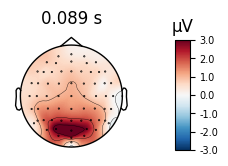

In [16]:
tim = np.linspace(0.089, 0.1, 1)
lim = (-3,3)
# up_ga.plot_topomap(ch_type="eeg", times= tim, colorbar=True, vlim = lim)
down_ga.plot_topomap(ch_type="eeg", times= tim, colorbar=True, vlim = lim)

In [11]:
gen_up_array = np.array(gen_up_data)
gen_down_array = np.array(gen_down_data)
up_array = np.array(up_data)
down_array = np.array(down_data)
norm_up_array = np.array(norm_up_data)
norm_down_array = np.array(norm_down_data)
# drop bad spans
gen_up_array[0,6,:] = np.nan
gen_down_array[1,6,:] = np.nan
gen_up_array[1,7,:] = np.nan
gen_down_array[0,7,:] = np.nan
up_array[0,6,:] = np.nan
down_array[1,6,:] = np.nan
up_array[1,7,:] = np.nan
down_array[0,7,:] = np.nan
norm_up_array[0,6,:] = np.nan
norm_down_array[1,6,:] = np.nan
norm_up_array[1,7,:] = np.nan
norm_down_array[0,7,:] = np.nan

gen_up_total = np.nanmean(gen_up_array,axis=1)
gen_down_total = np.nanmean(gen_down_array,axis=1)
up_total = np.nanmean(up_array,axis=1)
down_total = np.nanmean(down_array,axis=1)
norm_up_total = np.nanmean(norm_up_array,axis=1)
norm_down_total = np.nanmean(norm_down_array,axis=1)

NameError: name 'gen_up_data' is not defined

In [20]:
"""
Create plottign df
"""
# Flatten the array (i.e., stack all the data into one column)
flat_up = gen_up_array.flatten() # norm_up_array.flatten()
flat_down = gen_down_array.flatten() # norm_down_array.flatten()
flat = np.concatenate((flat_up,flat_down))
times = evoked_pos1_list[0].times
# Create arrays for position, subject, and timepoint
rep_conds = np.repeat(conditions, 23 * 155)  # Repeat each position 23 * 155 times
subjects = np.tile(np.repeat(sub_list, 155), 4)  # Repeat each subject 155 times for each position
timepoints = np.tile(times, 4 * 23)  

# Create the DataFrame
up_plot_df = pd.DataFrame({
    'subject': subjects,
    'times': timepoints,
    'condition': rep_conds,
    'amp': flat_up
})
# Create the DataFrame
down_plot_df = pd.DataFrame({
    'subject': subjects,
    'times': timepoints,
    'condition': rep_conds,
    'amp': flat_down
})

vf_field = np.repeat(['up', 'down'], 4 *23 * 155) 
# Create the DataFrame
plot_df = pd.DataFrame({
    'subject': np.tile(subjects,2),
    'times': np.tile(timepoints,2),
    'condition': np.tile(rep_conds,2),
    'visual_field':vf_field,
    'amp': flat
})

plot_df['rms_amp'] = np.sqrt(plot_df['amp']**2)
# Split the column based on an underscore (_)
plot_df[['attention', 'expectation']] = plot_df['condition'].str.split(' ', expand=True)

In [21]:
# Files with latencies based on localiser and 20 ms window
plot_df.to_csv(r'C:\Users\mvmigem\Documents\data\project_1\plotting_df\standard_c1_plot.csv',index= False)
# plot_df.to_csv(r'C:\Users\mvmigem\Documents\data\project_1\plotting_df\indivualised_c1_plot.csv',index= False)

In [22]:

# init fig
fig, axes = plt.subplots(2,3, figsize=(12, 6), sharey=True)
times = evoked_pos1_list[0].times

for idx in range(4):
    up_ga = evoked_ga_up[idx].get_data(['POz']).squeeze() * 1e6
    sns.lineplot(x=times, y=up_ga, ax = axes[0,0], label = ev_names[idx])
    norm_up = norm_up_total[idx,:]
    sns.lineplot(x=times, y=norm_up, ax = axes[0,1], label = ev_names[idx])
    up = up_total[idx,:]
    sns.lineplot(x=times, y=up, ax = axes[0,2], label = ev_names[idx])

    down_ga = evoked_ga_down[idx].get_data(['POz']).squeeze() * 1e6
    sns.lineplot(x=times, y=down_ga, ax = axes[1,0],label = ev_names[idx])
    norm_down = norm_down_total[idx,:]
    sns.lineplot(x=times, y=norm_down, ax = axes[1,1],label = ev_names[idx])
    down = down_total[idx,:]
    sns.lineplot(x=times, y=down, ax = axes[1,2],label = ev_names[idx])

for i, ax in enumerate(axes.flat):
    ax.axhline(y=0, lw=1, c='black' )
    ax.axhline(y=-4, ls ='--',lw=1, c='black' )
    ax.axhline(y=4, ls ='--',lw=1, c='black' )
    ax.axvline(x=.05,ls='--',lw=1, c='black' )
    ax.axvline(x=.1,ls='--',lw=1, c='black' )
sns.set_context("paper")
axes[0,0].set_title('Up POz')
axes[0,1].set_title('Up variable')
axes[0,2].set_title('Up very variable')
axes[1,0].set_title('Down POz')
axes[1,1].set_title('Down variable')
axes[1,2].set_title('Down very variable')
axes[0,0].set_ylabel('µV')
axes[1,0].set_ylabel('µV')
axes[1,0].set_xlabel('time (s)')
axes[1,1].set_xlabel('time (s)')

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the figure
plt.show()

In [32]:
# make rms plots for tailored evokeds
rms_total = np.mean([np.sqrt(norm_up_total**2),np.sqrt(norm_down_total**2)],axis=0)
rmsrms = np.sqrt(rms_total**2)
fig, axes = plt.subplots()
times = evoked_pos1_list[0].times
handles = ['Regular Attended','Odd Attended','Regular Unattented','Odd Unattended']

for idx in range(4):
    gwa = rms_total[idx,:]
    sns.lineplot(x=times, y=gwa, label = handles[idx])

axes.axhline(y=0, lw=1, c='black' )
axes.axhline(y=-4, ls ='--',lw=1, c='black' )
axes.axhline(y=4, ls ='--',lw=1, c='black' )
axes.axvline(x=.05,ls='--',lw=1, c='black' )
axes.axvline(x=.1,ls='--',lw=1, c='black' )

axes.set_title('Ultra RMS')
axes.set_ylabel('µV')
axes.set_xlabel('time (s)')
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the figure
plt.show()

In [158]:
import matplotlib.lines as mlines

fig, axes = plt.subplots(1, figsize=(16, 10), sharey=True, facecolor ='#C1E5F5')

times = evoked_pos1_list[0].times
handles = ['Regular Attended','Odd Attended','Regular Unattented','Odd Unattended']
line_colours = {'attended reg':my_palette[1],'attended odd':my_palette[1],'unattended reg':my_palette[2],'unattended odd':my_palette[2]}

att_up_vf = mlines.Line2D([], [], color=my_palette[1], linestyle='-', label='Attended Regular',linewidth=6)
unatt_up_vf = mlines.Line2D([], [], color=my_palette[1], linestyle='dotted', label='Attended Odd',linewidth=6)
att_down_vf = mlines.Line2D([], [], color= my_palette[2], linestyle='-', label='Unattented Regular',linewidth=6)
unatt_down_vf = mlines.Line2D([], [], color=my_palette[2], linestyle='dotted', label='Unattended Odd',linewidth=6)

sns.set_context("poster")

sns.lineplot(data=plot_df, x='times', y='rms_amp',hue='condition',
             palette = line_colours,ax=axes, linewidth=6,
             errorbar = 'se')
# Might need to loop through the list if there are multiple lines on the plot
axes.lines[1].set_linestyle("dotted")
axes.lines[3].set_linestyle("dotted")

plt.rcParams['font.family'] = 'Segoe UI'
plt.rcParams['font.weight'] = 'semibold'
legend = plt.legend(handles=[att_up_vf, unatt_up_vf,att_down_vf,unatt_down_vf,],
           loc='upper left', bbox_to_anchor=(-.01, 1),prop={'size':22},facecolor= 'white')

plt.gca().set_facecolor('#C1E5F5')
sns.despine(offset=10, trim=True);
for i in range(1):
    axes.axhline(y=0, lw=1, c='black' )
    axes.axhline(y=4, ls ='--',lw=1, c='black' )
    axes.axvline(x=.05,ls='--',lw=1, c='black' )
    axes.axvline(x=.1,ls='--',lw=1, c='black' )
    axes.set_ylabel('µV (absolute value)', fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':28})
    axes.set_xlabel('time (s)',fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':28})

sns.axes_style("ticks")
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the figure
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16, 6), sharey=True, facecolor ='#C1E5F5')

c1_very_long_df['rms_tailored'] = np.sqrt(c1_very_long_df['tailored_amp']**2)

att_label = mlines.Line2D([], [], color=my_palette[4], linestyle='-', label='Attended',linewidth=6)
unatt_label = mlines.Line2D([], [], color=my_palette[8], linestyle='-', label='Unattended',linewidth=6)
reg_label = mlines.Line2D([], [], color= my_palette[9], linestyle='-', label='Regular',linewidth=6)
odd_label = mlines.Line2D([], [], color=my_palette[6], linestyle='-', label='Odd',linewidth=6)

sns.barplot(c1_very_long_df, y= 'rms_tailored', x= 'visual_field', hue= 'attention', edgecolor= 'none', palette= [my_palette[4],my_palette[8]],
            errorbar='se', errwidth= 5,
            capsize=.1,width=.4, linewidth=0.7, ax=axes[0])

sns.barplot(c1_very_long_df , y= 'rms_tailored', x= 'visual_field', hue= 'expectation', edgecolor= 'none', palette= [my_palette[9],my_palette[6]],
            errorbar='se', errwidth= 5,
            capsize=.1,width=.4, linewidth=0.7, ax=axes[1])

plt.rcParams['font.family'] = 'Segoe UI'
plt.rcParams['font.weight'] = 'semibold'
sns.set_context("poster")
axes[0].set_ylim(0,5)
axes[0].set_facecolor('#C1E5F5')
axes[1].set_facecolor('#C1E5F5')
axes[0].legend(handles=[att_label,unatt_label],
           loc='upper left', bbox_to_anchor=(.65, 1),prop={'size':22},facecolor= 'white')
axes[1].legend(handles=[reg_label,odd_label],
           loc='upper left', bbox_to_anchor=(.65, 1),prop={'size':22},facecolor= 'white')

axes[0].set_ylabel('µV (absolute value)', fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':28})
axes[0].set_xlabel('Visual Field', fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':28})
axes[1].set_xlabel('Visual Field', fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':28})

sns.despine(offset=10, trim=True);
sns.axes_style("ticks")
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the figure
plt.show()

In [ ]:
fig, axes = plt.subplots(1, figsize=(16, 10), sharey=True, facecolor ='#C1E5F5')

c1_very_long_df['rms_tailored'] = np.sqrt(c1_very_long_df['tailored_amp']**2)

att_label = mlines.Line2D([], [], color=my_palette[4], linestyle='-', label='Attended',linewidth=6)
unatt_label = mlines.Line2D([], [], color=my_palette[8], linestyle='-', label='Unattended',linewidth=6)
reg_label = mlines.Line2D([], [], color= my_palette[9], linestyle='-', label='Regular',linewidth=6)
odd_label = mlines.Line2D([], [], color=my_palette[6], linestyle='-', label='Odd',linewidth=6)

bar_plot= sns.barplot(p3_df, y= 'mean_amp', x= 'expectation', hue= 'attention', palette= [my_palette[4],my_palette[8]],
            errorbar='se', errwidth= 7,
            capsize=.1,width=.4, linewidth=0.7)


plt.rcParams['font.family'] = 'Segoe UI'
plt.rcParams['font.weight'] = 'semibold'
sns.set_context("poster")

axes.set_facecolor('#C1E5F5')

axes.legend(handles=[att_label,unatt_label],
           loc='upper left', bbox_to_anchor=(.9, 1),prop={'size':36},facecolor= 'white')

axes.set_ylim(0,3)
axes.set_ylabel('µV', fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':48})
axes.set_xlabel('Expectation', fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':48})

bar_plot.spines['left'].set_linewidth(6)   # Set thickness for left spine
bar_plot.spines['bottom'].set_linewidth(6)
plt.tick_params(axis='both', width=6, length=12,labelsize = 36)

sns.despine(offset=10, trim=True);
sns.axes_style("ticks")
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the figure
plt.show()

In [20]:
"""
P1 and N1
"""
p1_els = ['PO4','PO8','O2','PO3','PO7','O1']
ev_names = ['reg_att','odd_att','reg_unatt','odd_unatt']

# make a df with the data we want
time = np.tile(evokeds_up['reg_att'][0].times,8)
el_li = np.empty()
for ec in ev_names:
    ddd2= evokeds_up['reg_att'][0].copy().pick(p1_els).T
    el_li.extend()



# position_up = np.full(len(time)/2,sub_pos_info[i]['up_pos'])
# position_down = np.full(len(time)/2,sub_pos_info[i]['down_pos'])


